In [1]:
from utilities import * 

In [3]:
fires, aqi = load_data(fire_csv="datasets/fires.csv", aqi_csv="datasets/daily_aqi_by_county_2007.csv")
fires.head(5)

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE_NAME,COUNTY_NAME,STATE_CODE,COUNTY_CODE
0,TONSINA CREEK,2005,2.3,2005-04-28,2005-04-29,Campfire,Alaska,Kenai Peninsula,2,122
1,PETERSON CREEK,2005,2.5,2005-05-08,2005-05-10,Miscellaneous,Alaska,Kenai Peninsula,2,122
2,TWENTY MILE,2005,0.1,2005-05-09,2005-05-09,Debris Burning,Alaska,Kenai Peninsula,2,122
3,MOTORHOME,2007,0.1,2007-06-01,2007-06-01,Miscellaneous,Alaska,Kenai Peninsula,2,122
4,POWER,2007,0.1,2007-06-09,2007-06-09,Campfire,Alaska,Kenai Peninsula,2,122


In [4]:
fires_ = get_fires(df = fires, state=None, county=None, year=2007, date=None)
fires_["MONTH"] = pd.DatetimeIndex(fires_['DISCOVERY_DATE']).month
fires_["DURATION"] = (pd.to_datetime(fires_["CONT_DATE"]) - pd.to_datetime(fires_["DISCOVERY_DATE"]))
columns=["COUNTY_NAME", "MONTH", "DURATION", "FIRE_SIZE"]
fires_ = fires_[columns]
print(fires_.shape)
fires_ = fires_.dropna(subset = ["COUNTY_NAME", "MONTH"])
print(fires_.shape)

fires_["DURATION"] = fires_["DURATION"].dt.days

fires_["DURATION"] += 1.0
duration = fires_["DURATION"]

# If there is a missing value in dates, we assume it last for 2 days
fires_["DURATION"] = fires_["DURATION"].fillna(2.0)
# If the fire size is unavailabe, we assume it to be 0.5
fires_["FIRE_SIZE"] = fires_["FIRE_SIZE"].fillna(0.5)
fires_["FIRE_SUM"] = fires_["DURATION"] * fires_["FIRE_SIZE"]

columns = ["COUNTY_NAME", "MONTH", "FIRE_SUM"]
fires_ = fires_[columns]
fires_groupBy = fires_.groupby(["COUNTY_NAME", "MONTH"])["FIRE_SUM"].sum().reset_index()
fires_groupBy

(73367, 4)
(73367, 4)


/home/froi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/froi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,COUNTY_NAME,MONTH,FIRE_SUM
0,Abbeville,1,2.20
1,Abbeville,2,34.20
2,Abbeville,3,36.60
3,Abbeville,4,27.00
4,Abbeville,5,130.08
...,...,...,...
9219,Yuma,7,0.10
9220,Yuma,10,3657.00
9221,Zavala,7,0.40
9222,Zavala,10,324.00


In [5]:
aqi["MONTH"] = pd.DatetimeIndex(aqi['DATE']).month
columns = ["COUNTY_NAME", "MONTH", "AQI"]
aqi_ = aqi[columns]
#aqi_.rename(columns = {"COUNTY_NAME": "COUNTY_NAME"}, inplace = True)
aqi_groupBy = aqi_.groupby(["COUNTY_NAME", "MONTH"]).mean().reset_index()
aqi_groupBy

,COUNTY_NAME,MONTH,AQI
0,Abbeville,3,68.240000
1,Abbeville,4,67.933333
2,Abbeville,5,74.806452
3,Abbeville,6,68.275862
4,Abbeville,7,51.774194
...,...,...,...
9649,Yuma,8,47.967742
9650,Yuma,9,53.566667
9651,Yuma,10,56.645161
9652,Yuma,11,44.900000


In [6]:
correlation = pd.DataFrame.merge(fires_groupBy, aqi_groupBy, how = "inner")
# fires_groupBy.join(aqi_groupBy, on = ["COUNTY_NAME", "MONTH"], how = "inner")
correlation

,COUNTY_NAME,MONTH,FIRE_SUM,AQI
0,Abbeville,3,36.60,68.240000
1,Abbeville,4,27.00,67.933333
2,Abbeville,5,130.08,74.806452
3,Abbeville,6,12.60,68.275862
4,Abbeville,7,3.80,51.774194
...,...,...,...,...
4846,Yuma,2,116.20,56.928571
4847,Yuma,5,2750.90,65.741935
4848,Yuma,6,264.00,67.600000
4849,Yuma,7,0.10,49.000000


From the scatter plot,  we can tell that the major factor of high AQI is not due to wildfire. Even though, there's occurance of huge wildfires, the AQI does not result in drastic increase.

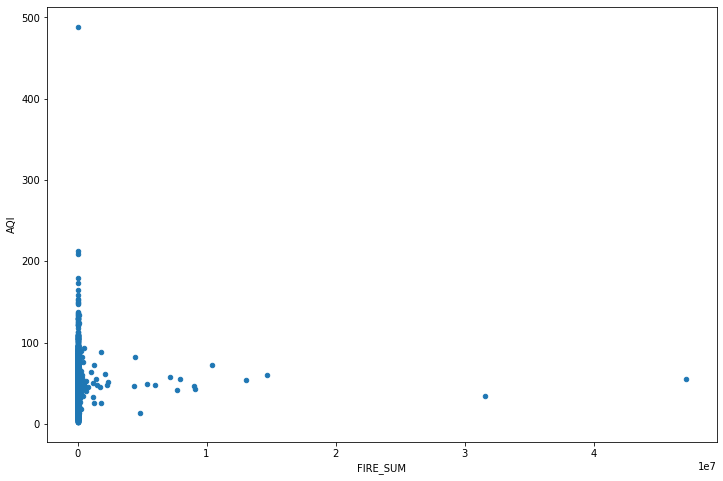

In [7]:
correlation[['FIRE_SUM','AQI']].plot(
    kind='scatter',
    x='FIRE_SUM',
    y='AQI',
    figsize=(12,8)
)